# Monte Carlo Turtle Trading

In this notebook, I explore the performance of the Turtle trading strategy on randomly generated price series. In particular, I explore 2 areas:
1. Using leveraged ETFs vs underlying asset (UPRO vs SPY)
2. Hedging with calls.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester
from mpl_toolkits.mplot3d import Axes3D
import optuna
from tqdm.notebook import tqdm
import scipy as sp



ticker = 'SPY'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

df['ret'] = df['close'].pct_change()

mu = df['ret'].mean()
sigma = df['ret'].std()

print('Daily returns')
print(f'mean: {mu}, vol: {sigma}')

Daily returns
mean: 0.00037208709407292345, vol: 0.011913273091521077


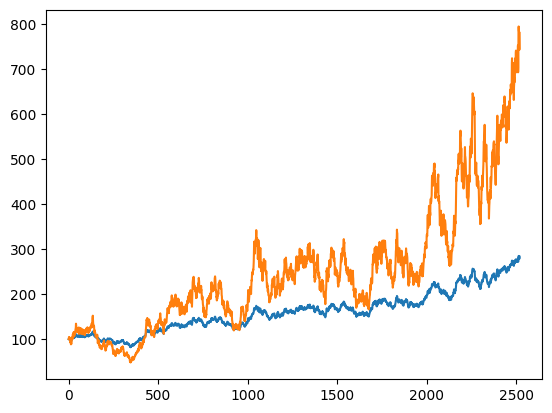

In [2]:
price_series, lev_price_series = misc.generate_price_series_norm(mu, sigma, 100, 2520, 3)
plt.plot(price_series)
plt.plot(lev_price_series)
plt.show()

In [3]:
def generate_price_df(mean, volatility, length, initial_price=100, leverage=3):
    close, lev_close = misc.generate_price_series_norm(
        mean=mean, 
        volatility=volatility, 
        num_days=length, 
        initial_price=initial_price,
        leverage=leverage
        )
    df = pd.DataFrame({
        'open': close,
        'high': close,
        'low': close, 
        'close': close,
        'adjclose': close,
    })

    lev_df = pd.DataFrame({
        'open': lev_close,
        'high': lev_close,
        'low': lev_close, 
        'close': lev_close,
        'adjclose': lev_close,
    })


    return df, lev_df

    

Modify the indicator and trading strategy to use 1 price per day.

In [4]:
def generate_high_low(df, high_window, low_window):

    df['up_bound'] = df['close'].shift(1).rolling(high_window).max()
    df['low_bound'] = df['close'].shift(1).rolling(low_window).min()

    return df

def generate_atr(df, window):
    df['TR'] = abs(df['close'] - df['close'].shift(1))
    df['ATR'] = df['TR'].rolling(window).mean()
    return df



In [5]:
def hatr_backtest(df, high_window, low_window, atr_window, atr_multiple):

    df = generate_high_low(df, high_window=high_window, low_window=low_window)
    df = generate_atr(df, atr_window)

    df['ATR'] = df['ATR'].shift(1)
    

    df.dropna(inplace=True)
    atr = df['ATR'].to_numpy()

    df['signal'] = 0

    # Generate trading signals
    df.loc[df['close'].shift(1) > df['up_bound'].shift(2), 'signal'] = 1    

    trades_arr = df['signal'].to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None
    stop_loss = np.nan
    stop_arr = []
    

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0
        

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.close[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            n3 = atr_multiple * atr[i]
            stop_loss = order_price - n3
            
        # open trades present 
        elif open_trade != None:
            stop_loss = max(stop_loss, bt.close[i - 1] - n3, df['low_bound'].to_numpy()[i])
            if bt.low[i] < stop_loss:

                order_price = stop_loss
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)
                
                open_trade = None
                stop_loss = np.nan
        
        stop_arr.append(stop_loss)

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
    bt.df['stop_loss'] = stop_arr

    return bt, tl

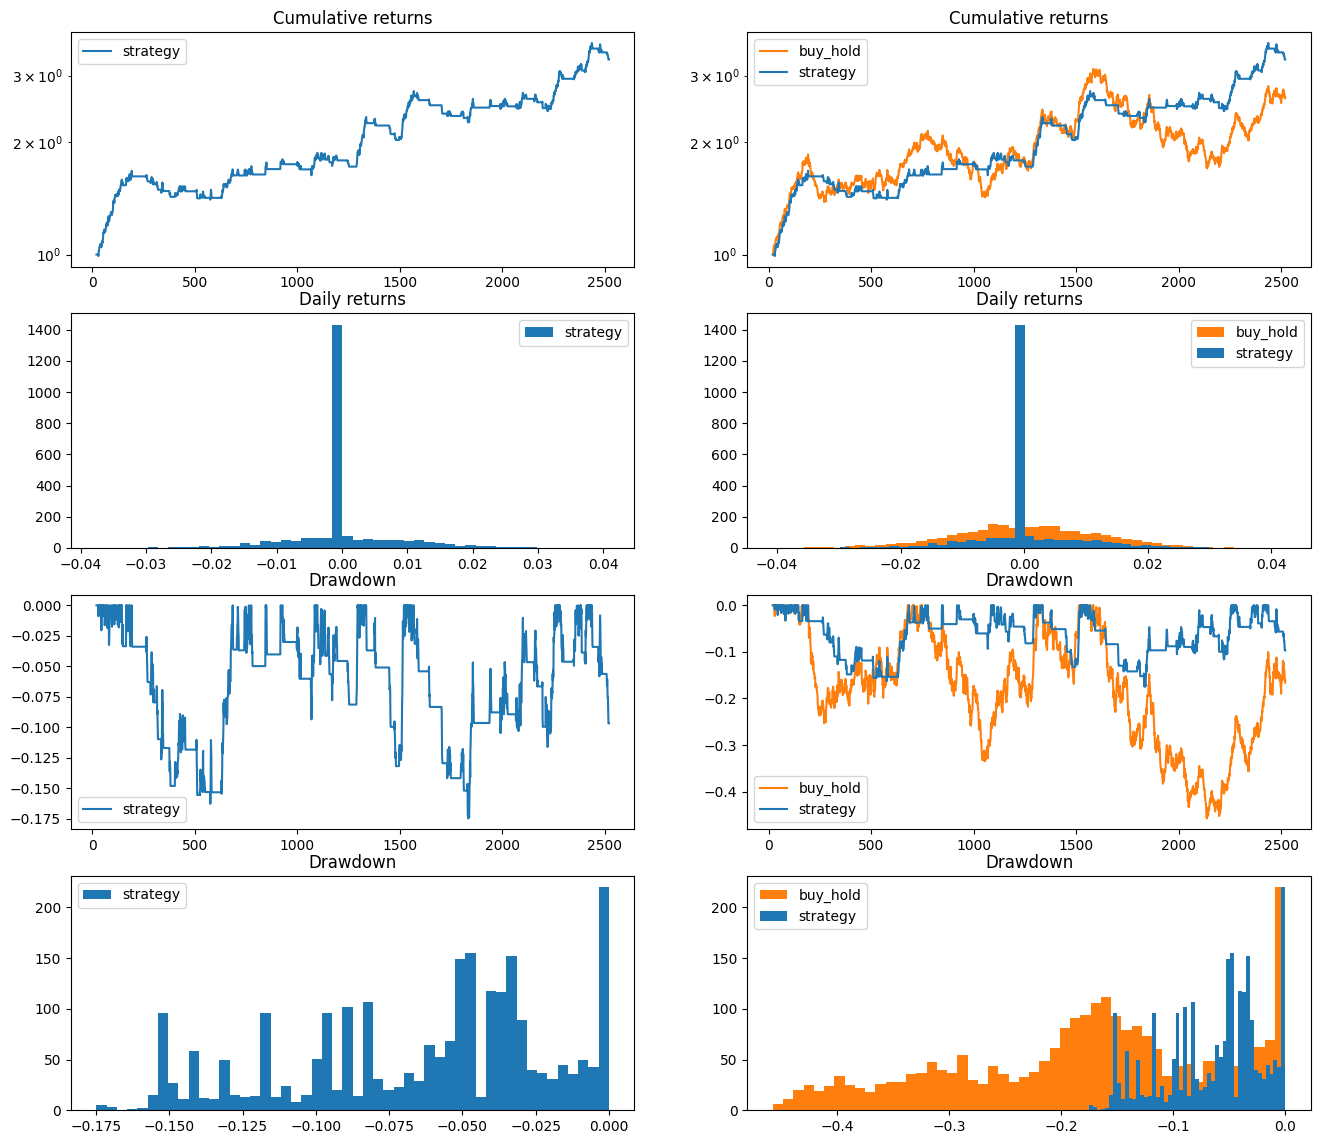

In [6]:
df, lev_df = generate_price_df(mean=mu, volatility=sigma, length=2520)

bt, tl = hatr_backtest(df, 20, 20, 20, 5)
bt.analyse()
bt.plot_graphs()

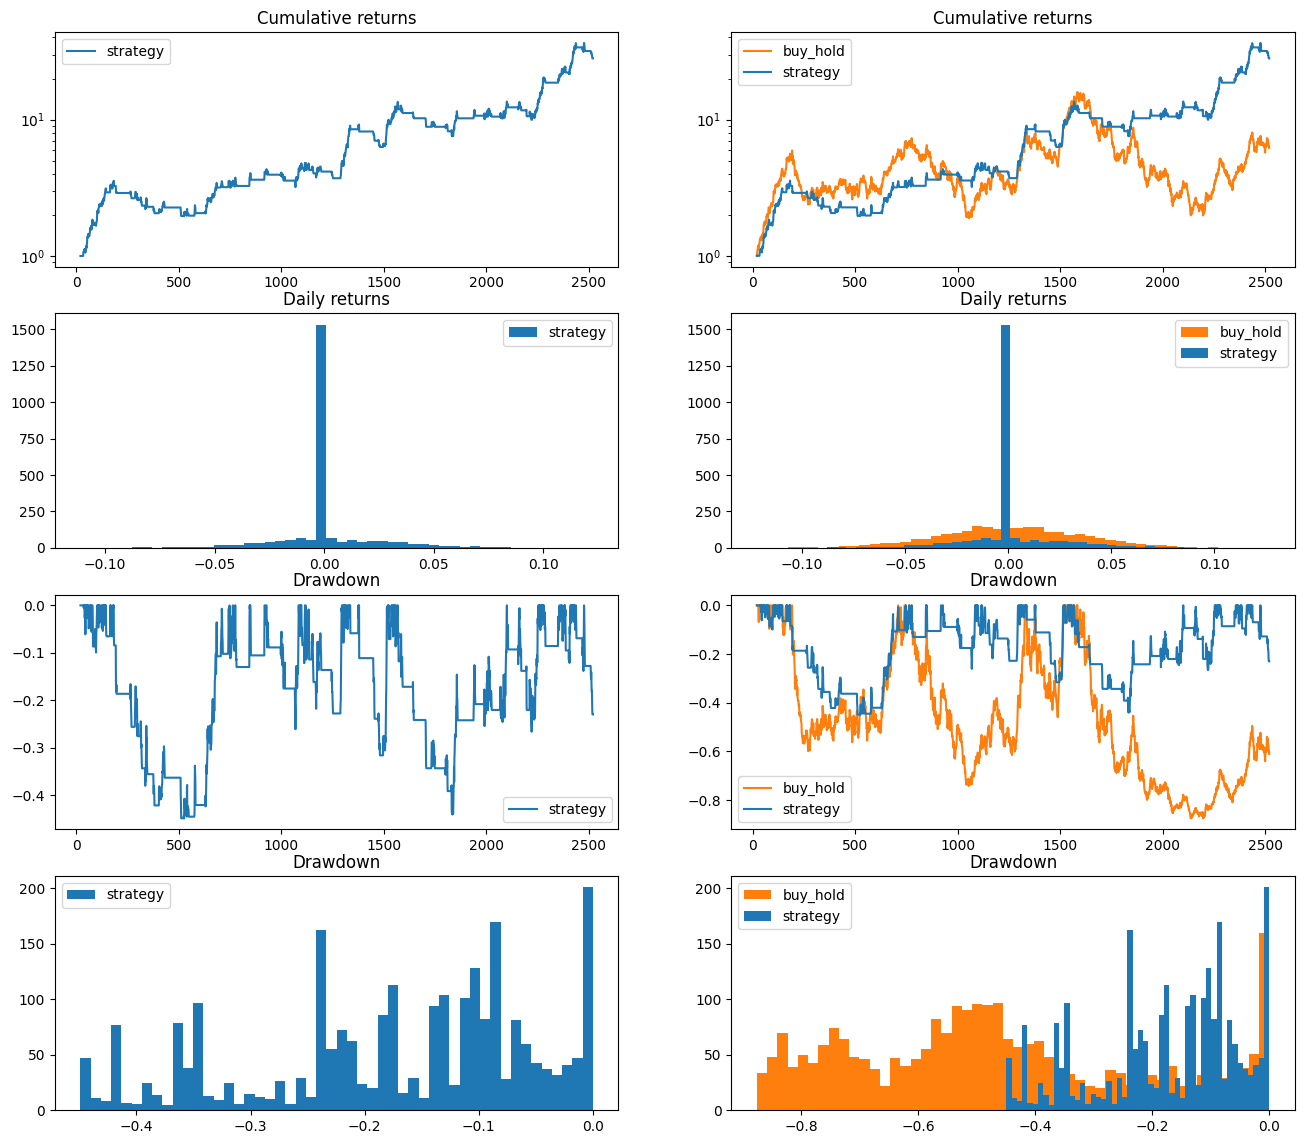

In [7]:
lev_bt, lev_tl = hatr_backtest(lev_df, 20, 20, 20, 5)
lev_bt.analyse()
lev_bt.plot_graphs()

In [8]:
print('Returns')
print(f'buy_hold:           {bt.buy_hold_annual_return}')
print(f'leveraged_buy_hold: {lev_bt.buy_hold_annual_return}')
print(f'strat:              {bt.annual_return}')
print(f'leveraged_strat:    {lev_bt.annual_return}')

print('--------------')
print('Sharpe Ratio')
print(f'buy_hold:           {bt.buy_hold_sharpe}')
print(f'leveraged_buy_hold: {lev_bt.buy_hold_sharpe}')
print(f'strat:              {bt.sharpe}')
print(f'leveraged_strat:    {lev_bt.sharpe}')

Returns
buy_hold:           0.1504716766520735
leveraged_buy_hold: 0.3055727207276271
strat:              0.19129450962328587
leveraged_strat:    0.6282263568977551
--------------
Sharpe Ratio
buy_hold:           0.8003735074650881
leveraged_buy_hold: 0.5417903570870025
strat:              1.5911274556610024
leveraged_strat:    1.825783581111288


In [9]:
def monte_carlo_test(mu, sigma, length, num_trials, high_window, low_window, atr_window, atr_mult):

    res_dict = {
        'ret': [],
        'bh_ret': [],
        'vol': [],
        'bh_vol': [],
    }

    lev_res_dict = {
        'ret': [],
        'bh_ret': [],
        'vol': [],
        'bh_vol': [],
    }

    for i in range(num_trials):
        df, lev_df = generate_price_df(mean=mu, volatility=sigma, length=length)

        bt, _ = hatr_backtest(df, 
                              high_window=high_window, 
                              low_window=low_window, 
                              atr_window=atr_window, 
                              atr_multiple=atr_mult
                              )
        bt.analyse()

        res_dict['ret'].append(bt.annual_return)
        res_dict['vol'].append(bt.annual_vol)
        res_dict['bh_ret'].append(bt.buy_hold_annual_return)
        res_dict['bh_vol'].append(bt.buy_hold_annual_vol)


        bt, _ = hatr_backtest(lev_df, 
                              high_window=high_window, 
                              low_window=low_window, 
                              atr_window=atr_window, 
                              atr_multiple=atr_mult)
        bt.analyse()

        # lret.append(bt.annual_return - bt.buy_hold_annual_return)
        # lvol.append(bt.annual_vol - bt.buy_hold_annual_vol)
        # lsharpe.append(bt.sharpe - bt.buy_hold_sharpe)

        lev_res_dict['ret'].append(bt.annual_return)
        lev_res_dict['vol'].append(bt.annual_vol)
        lev_res_dict['bh_ret'].append(bt.buy_hold_annual_return)
        lev_res_dict['bh_vol'].append(bt.buy_hold_annual_vol)

    for i in res_dict:
        res_dict[i] = np.array(res_dict[i])
        lev_res_dict[i] = np.array(lev_res_dict[i])
    
    return res_dict, lev_res_dict


In [10]:
res_dict, lev_res_dict = monte_carlo_test(mu, sigma, 252, 1000, 20, 20, 20, 5)
print('Returns')
print(f'buy_hold:       {np.mean(res_dict["bh_ret"])}')
print(f'strat:          {np.mean(res_dict["ret"])}')
print(f'lev_buy_hold:   {np.mean(lev_res_dict["bh_ret"])}')
print(f'lev_strat:      {np.mean(lev_res_dict["ret"])}')
print('-----------------')

print('Vol')
print(f'buy_hold:       {np.mean(res_dict["bh_vol"])}')
print(f'strat:          {np.mean(res_dict["vol"])}')
print(f'lev_buy_hold:   {np.mean(lev_res_dict["bh_vol"])}')
print(f'lev_strat:      {np.mean(lev_res_dict["vol"])}')
print('-----------------')

print('Sharpe')
print(f'buy_hold:       {np.mean(res_dict["bh_ret"] / res_dict["bh_vol"])}')
print(f'strat:          {np.mean(res_dict["ret"] / res_dict["vol"])}')
print(f'lev_buy_hold:   {np.mean(lev_res_dict["bh_ret"] / lev_res_dict["bh_vol"])}')
print(f'lev_strat:      {np.mean(lev_res_dict["ret"] / lev_res_dict["vol"])}')
print('-----------------')

Returns
buy_hold:       0.14689454000164556
strat:          0.10665043563621512
lev_buy_hold:   0.6566126882768059
lev_strat:      0.4144198788310731
-----------------
Vol
buy_hold:       0.18830359666696528
strat:          0.11763199811310644
lev_buy_hold:   0.5649107900008958
lev_strat:      0.33244241075063247
-----------------
Sharpe
buy_hold:       0.7804124347264679
strat:          0.7287628498761157
lev_buy_hold:   1.164482079961199
lev_strat:      1.0257927958237838
-----------------


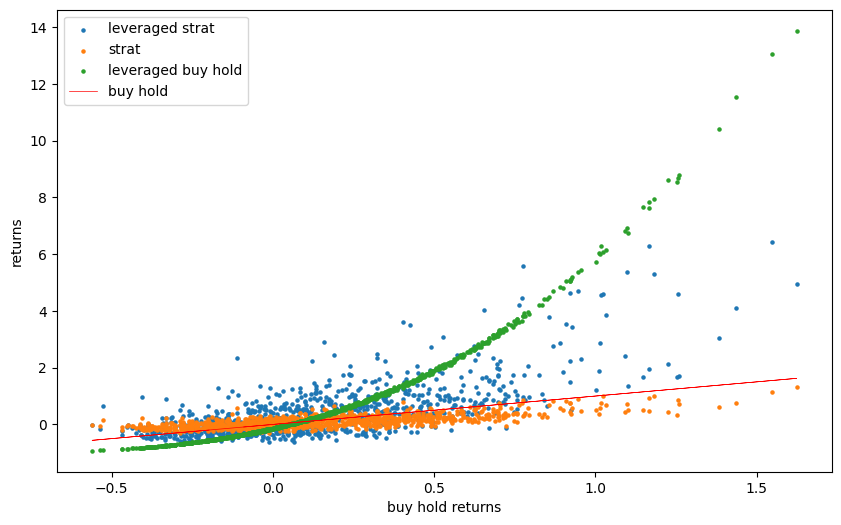

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(res_dict['bh_ret'], lev_res_dict['ret'], label='leveraged strat', s=5)
plt.scatter(res_dict['bh_ret'], res_dict['ret'], label='strat', s=5)
plt.scatter(res_dict['bh_ret'], lev_res_dict['bh_ret'], label='leveraged buy hold', s=5)
plt.plot(res_dict['bh_ret'], res_dict['bh_ret'], color='red', linewidth=0.5, label='buy hold')
plt.xlabel('buy hold returns')
plt.ylabel('returns')

plt.legend()
plt.show()

This graph shows the 1-year (252 days) returns of the turtle trading strategy, buy-hold on a levered ETF, and turtle trading on a levered ETF. 

Buy-hold on the levered ETF outperforms buy-hold on the underlying if the eventual returns are high. Leveraged buy-hold outperformance is exponentially increasing as we would expect, given that there is less likely to be whipsaw scenarios that cause volatility drag.

Turtle trading on the underlying outperforms buy-hold on the underlying when eventual returns are low and underperforms when eventual returns are high.

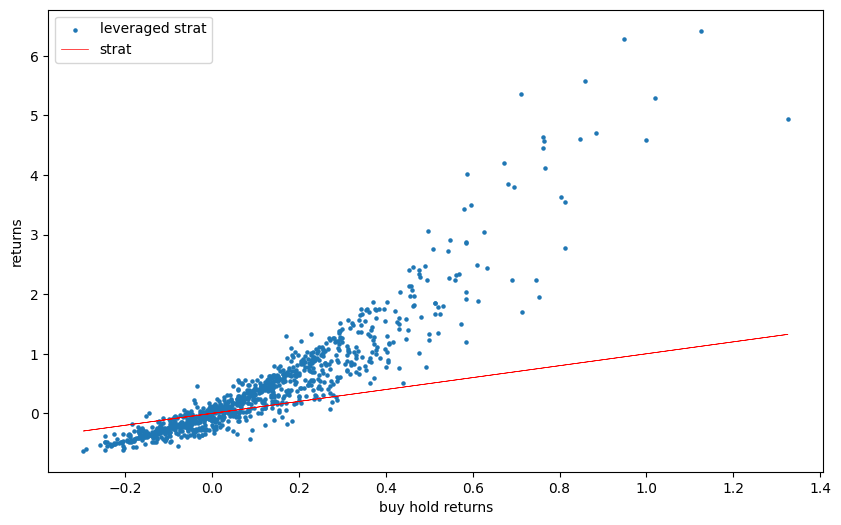

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(res_dict['ret'], lev_res_dict['ret'], label='leveraged strat', s=5)
# plt.scatter(res_dict['bh_ret'], res_dict['ret'], label='strat', s=5)
# plt.scatter(res_dict['bh_ret'], lev_res_dict['bh_ret'], label='leveraged buy hold', s=5)
plt.plot(res_dict['ret'], res_dict['ret'], color='red', linewidth=0.5, label='strat')
plt.xlabel('buy hold returns')
plt.ylabel('returns')

plt.legend()
plt.show()

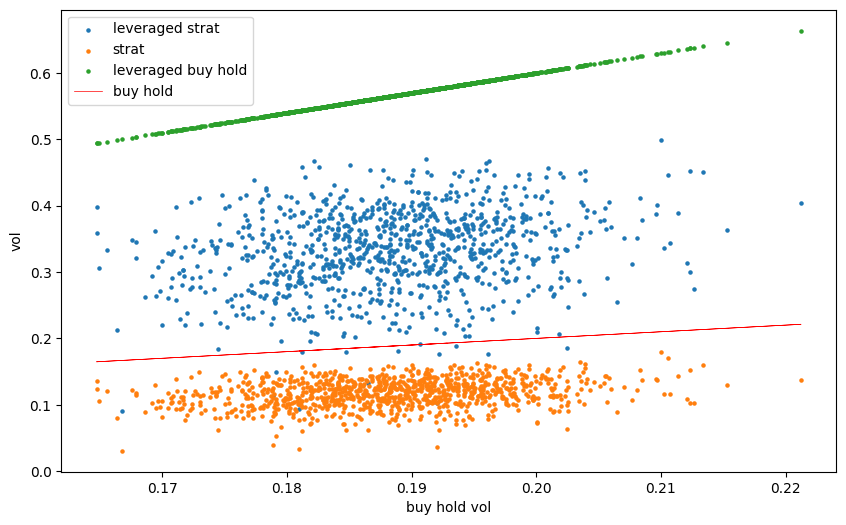

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(res_dict['bh_vol'], lev_res_dict['vol'], label='leveraged strat', s=5)
plt.scatter(res_dict['bh_vol'], res_dict['vol'], label='strat', s=5)
plt.scatter(res_dict['bh_vol'], lev_res_dict['bh_vol'], label='leveraged buy hold', s=5)
plt.plot(res_dict['bh_vol'], res_dict['bh_vol'], color='red', linewidth=0.5, label='buy hold')
plt.xlabel('buy hold vol')
plt.ylabel('vol')

plt.legend()
plt.show()

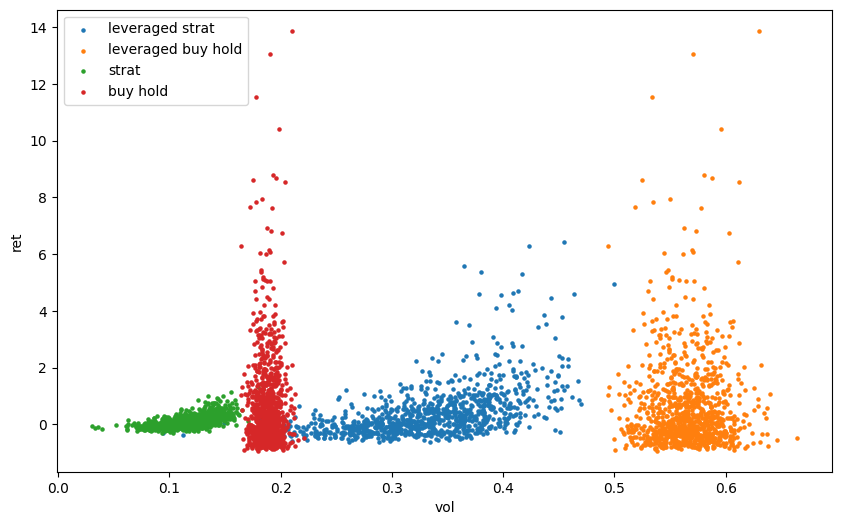

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(lev_res_dict['vol'], lev_res_dict['ret'], label='leveraged strat', s=5)
plt.scatter(lev_res_dict['bh_vol'], lev_res_dict['bh_ret'], label='leveraged buy hold', s=5)
plt.scatter(res_dict['vol'], res_dict['ret'], label='strat', s=5)
plt.scatter(res_dict['bh_vol'], lev_res_dict['bh_ret'], label='buy hold', s=5)
# plt.plot(res_dict['bh_vol'], res_dict['bh_vol'], color='red', linewidth=0.5, label='buy hold')
plt.xlabel('vol')
plt.ylabel('ret')

plt.legend()
plt.show()

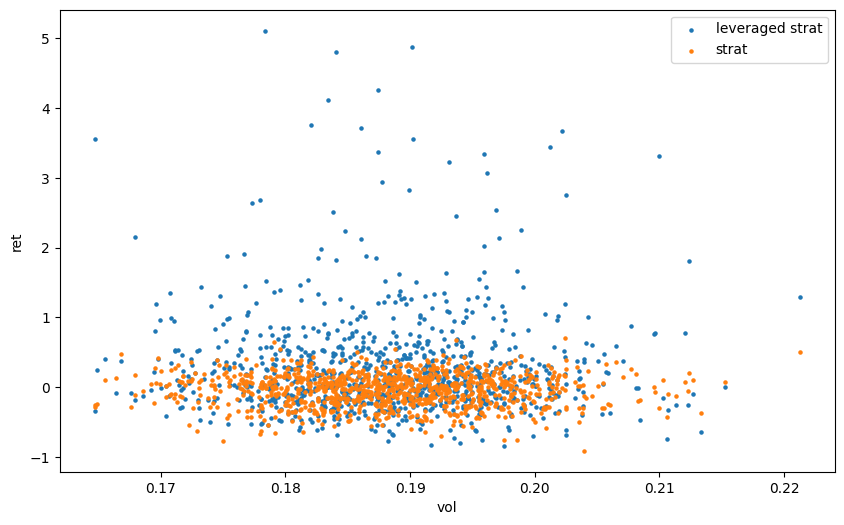

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(res_dict['bh_vol'], lev_res_dict['ret']  - res_dict['bh_ret'], label='leveraged strat', s=5)
# plt.scatter(lev_res_dict['bh_vol'], lev_res_dict['bh_ret'], label='leveraged buy hold', s=5)
plt.scatter(res_dict['bh_vol'], res_dict['ret'] - res_dict['bh_ret'], label='strat', s=5)
# plt.scatter(res_dict['bh_vol'], lev_res_dict['bh_ret'], label='buy hold', s=5)
# plt.plot(res_dict['bh_vol'], res_dict['bh_vol'], color='red', linewidth=0.5, label='buy hold')
plt.xlabel('vol')
plt.ylabel('ret')

plt.legend()
plt.show()

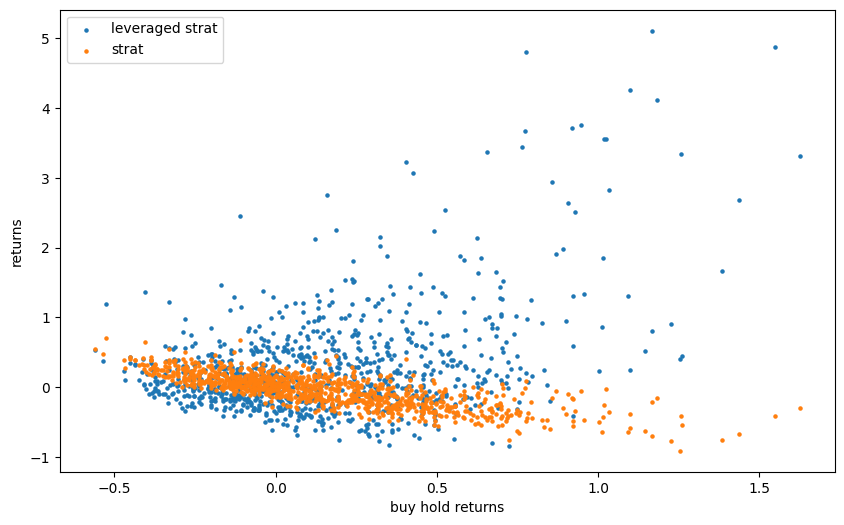

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(res_dict['bh_ret'], lev_res_dict['ret'] - res_dict['bh_ret'], label='leveraged strat', s=5)
plt.scatter(res_dict['bh_ret'], res_dict['ret'] - res_dict['bh_ret'], label='strat', s=5)
# plt.scatter(res_dict['bh_ret'], lev_res_dict['bh_ret'], label='leveraged buy hold', s=5)
# plt.plot(res_dict['bh_ret'], res_dict['bh_ret'], color='red', linewidth=0.5, label='buy hold')
plt.xlabel('buy hold returns')
plt.ylabel('returns')

plt.legend()
plt.show()

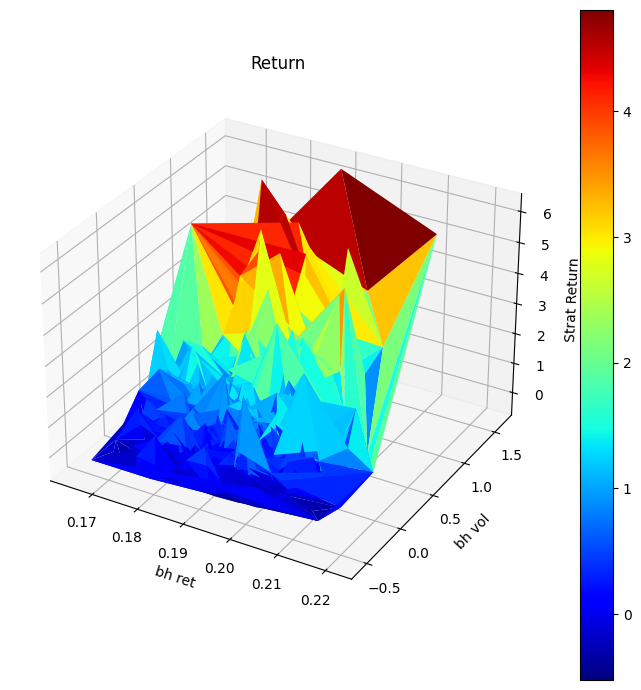

In [17]:
x = res_dict['bh_vol']
y = res_dict['bh_ret']
z = lev_res_dict['ret']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('bh ret')
ax.set_ylabel('bh vol')
ax.set_zlabel('Strat Return')
ax.set_title('Return')

fig.tight_layout()

plt.show()

In [18]:
length_dict = {
    'ret': [],
    'bh_ret': [],
    'lret': [],
    'bh_lret': [],
    'vol': [],
    'bh_vol': [],
    'lvol': [],
    'bh_lvol': [],
    'sr': [],
    'bh_sr': [],
    'lsr': [],
    'bh_lsr': [],
}
length_arr = []
for i in tqdm(range(252, 2523, 50)):
    length_arr.append(i)
    res_dict, lev_res_dict = monte_carlo_test(mu, sigma, i, 1000, 20, 20, 20, 5)
    length_dict['ret'].append(np.mean(res_dict['ret']))
    length_dict['bh_ret'].append(np.mean(res_dict['bh_ret']))
    length_dict['lret'].append(np.mean(lev_res_dict['ret']))
    length_dict['bh_lret'].append(np.mean(lev_res_dict['bh_ret']))

    length_dict['vol'].append(np.mean(res_dict['vol']))
    length_dict['bh_vol'].append(np.mean(res_dict['bh_vol']))
    length_dict['lvol'].append(np.mean(lev_res_dict['vol']))
    length_dict['bh_lvol'].append(np.mean(lev_res_dict['bh_vol']))

    length_dict['sr'].append(np.mean(res_dict['ret'] / res_dict['vol']))
    length_dict['bh_sr'].append(np.mean(res_dict['bh_ret'] / res_dict['bh_vol']))
    length_dict['lsr'].append(np.mean(lev_res_dict['ret'] / lev_res_dict['vol']))
    length_dict['bh_lsr'].append(np.mean(lev_res_dict['bh_ret'] / lev_res_dict['bh_vol']))

  0%|          | 0/46 [00:00<?, ?it/s]

c:\Users\alexr\Quantitative_Finance_Modelling\simple_backtester.py:136: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = self.annual_return / self.annual_vol
c:\Users\alexr\Quantitative_Finance_Modelling\simple_backtester.py:136: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = self.annual_return / self.annual_vol
C:\Users\alexr\AppData\Local\Temp\ipykernel_6508\990048474.py:29: RuntimeWarning: invalid value encountered in divide
  length_dict['sr'].append(np.mean(res_dict['ret'] / res_dict['vol']))
C:\Users\alexr\AppData\Local\Temp\ipykernel_6508\990048474.py:31: RuntimeWarning: invalid value encountered in divide
  length_dict['lsr'].append(np.mean(lev_res_dict['ret'] / lev_res_dict['vol']))


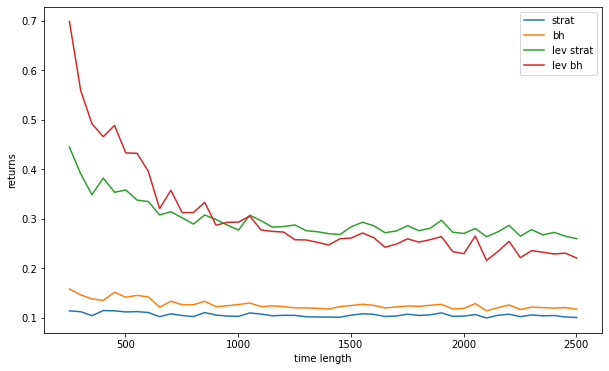

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(length_arr, length_dict['ret'], label='strat')
plt.plot(length_arr, length_dict['bh_ret'], label='bh')
plt.plot(length_arr, length_dict['lret'], label='lev strat')
plt.plot(length_arr, length_dict['bh_lret'], label='lev bh')
plt.legend()
plt.xlabel('time length')
plt.ylabel('returns')
plt.show()

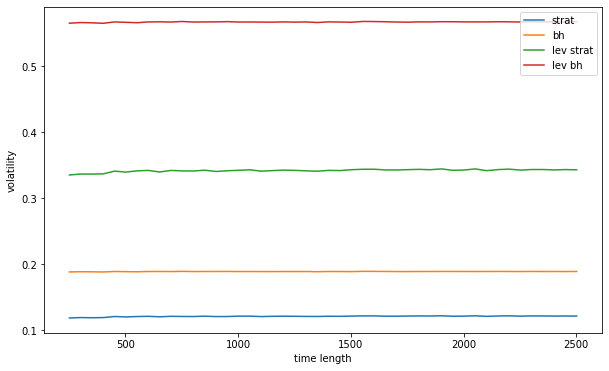

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(length_arr, length_dict['vol'], label='strat')
plt.plot(length_arr, length_dict['bh_vol'], label='bh')
plt.plot(length_arr, length_dict['lvol'], label='lev strat')
plt.plot(length_arr, length_dict['bh_lvol'], label='lev bh')
plt.legend()
plt.xlabel('time length')
plt.ylabel('volatility')
plt.show()

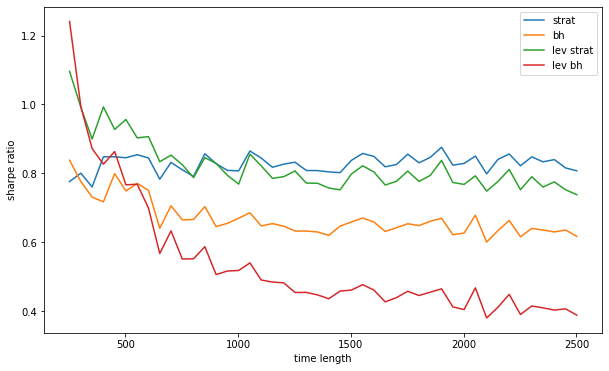

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(length_arr, length_dict['sr'], label='strat')
plt.plot(length_arr, length_dict['bh_sr'], label='bh')
plt.plot(length_arr, length_dict['lsr'], label='lev strat')
plt.plot(length_arr, length_dict['bh_lsr'], label='lev bh')
plt.legend()
plt.xlabel('time length')
plt.ylabel('sharpe ratio')
plt.show()

We predict that turtle trading (and other momentum-based strategies) are susceptible to whipsaw losses. This means that the price trend breaks out from the previous high and then reverses immediately for a loss, before reversing back to the upside. This causes the turtle trading strategy to underperform a buy-hold strategy. 

This means that the prices series may have cyclical movements with periods that are related to the high/low window. Therefore, we can do a fast fourier transform to see the frequency distribution and relate this to the profitability of the strategy.

2277.3976577083404


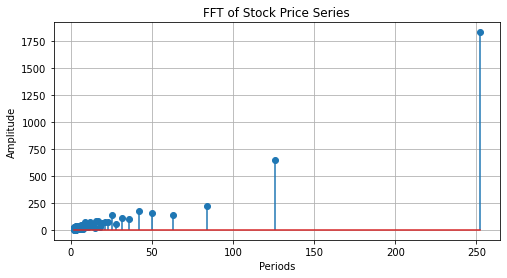

In [ ]:
from scipy.fft import fft, fftfreq

# Sample stock price data (replace this with your actual price series)
df, lev_df = generate_price_df(mean=mu, volatility=sigma, length=252)

# Calculate the FFT
fft_result = fft(df['close'].to_numpy())

# Get the frequencies corresponding to the FFT result
frequencies = fftfreq(len(df['close'].to_numpy()))
fft_result = abs(fft_result)
fft_result = fft_result[1:len(fft_result) // 2]
frequencies = frequencies[1:len(frequencies) // 2]
periods = 1 / frequencies

low_period_sum = np.sum(fft_result[12:])
print(low_period_sum)

# Plot the FFT result
plt.figure(figsize=(8, 4))
plt.stem(periods, fft_result)
plt.title('FFT of Stock Price Series')
plt.xlabel('Periods')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



In [ ]:
def fft_monte_carlo(mu, sigma, length, cut_off, num_trials):
    res_dict = {
        'ret': [],
        'bh_ret': [],
        'vol': [],
        'bh_vol': [],
    }

    lev_res_dict = {
        'ret': [],
        'bh_ret': [],
        'vol': [],
        'bh_vol': [],
    }

    low_period_sum_arr = []

    for _ in tqdm(range(num_trials)):
        # Sample stock price data (replace this with your actual price series)
        df, lev_df = generate_price_df(mean=mu, volatility=sigma, length=length)

        # Calculate the FFT
        fft_result = fft(df['close'].to_numpy())

        # Get the frequencies corresponding to the FFT result
        frequencies = fftfreq(len(df['close'].to_numpy()))
        fft_result = abs(fft_result)
        fft_result = fft_result[1:len(fft_result) // 2]
        frequencies = frequencies[1:len(frequencies) // 2]
        periods = 1 / frequencies

        low_period_sum = np.sum(fft_result[cut_off:])
        low_period_sum_arr.append(low_period_sum)

        bt, _ = hatr_backtest(df, 
                            high_window=20, 
                            low_window=20, 
                            atr_window=20, 
                            atr_multiple=3
                            )
        bt.analyse()

        res_dict['ret'].append(bt.annual_return)
        res_dict['vol'].append(bt.annual_vol)
        res_dict['bh_ret'].append(bt.buy_hold_annual_return)
        res_dict['bh_vol'].append(bt.buy_hold_annual_vol)


        bt, _ = hatr_backtest(lev_df, 
                            high_window=20, 
                            low_window=20, 
                            atr_window=20, 
                            atr_multiple=3)
        bt.analyse()



        lev_res_dict['ret'].append(bt.annual_return)
        lev_res_dict['vol'].append(bt.annual_vol)
        lev_res_dict['bh_ret'].append(bt.buy_hold_annual_return)
        lev_res_dict['bh_vol'].append(bt.buy_hold_annual_vol)

    for i in res_dict:
        res_dict[i] = np.array(res_dict[i])
        lev_res_dict[i] = np.array(lev_res_dict[i])

    return res_dict, lev_res_dict, low_period_sum_arr
    
    

In [ ]:
rd, lrd, lpsa = fft_monte_carlo(mu, sigma, 252 * 3, 10, 1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

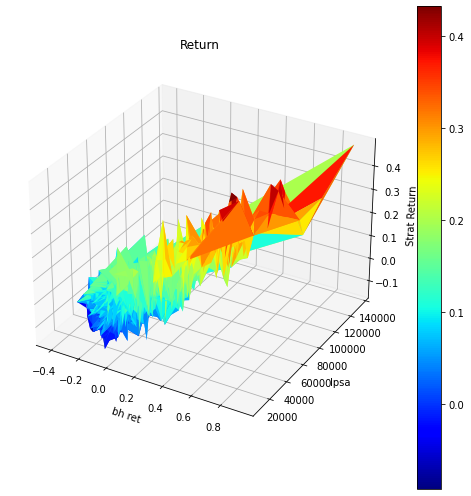

In [ ]:
x = rd['bh_ret']
y = lpsa
z = rd['ret']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('bh ret')
ax.set_ylabel('lpsa')
ax.set_zlabel('Strat Return')
ax.set_title('Return')

fig.tight_layout()

plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Sample data
data = {
    'x1': lpsa,
    'x2': rd['bh_ret'],
    'x3': rd['bh_vol'],
    'y': lrd['ret'],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Separate the independent variables (X) and the dependent variable (y)
X = df[['x1', 'x2', 'x3']]
y = df['y']

# Create the linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Get the coefficients (intercept, slope1, and slope2)
intercept = model.intercept_
coefficients = model.coef_

print("Intercept (b0):", intercept)
print("Coefficient for x1 (b1):", coefficients[0])
print("Coefficient for x2 (b2):", coefficients[1])
print("Coefficient for x3 (b3):", coefficients[2])


Intercept (b0): 0.019555660964112487
Coefficient for x1 (b1): 4.996282900793082e-06
Coefficient for x2 (b2): 0.9584499590589561
Coefficient for x3 (b3): 0.2896262180623604


In [ ]:


def objective(trial):
    # Define the parameters to optimize
    h_wind = trial.suggest_int('high_window', 5, 200)
    l_wind = trial.suggest_int('low_window', 5, 200)
    atr_wind = trial.suggest_int('atr_window', 5, 100)
    atr_mult = trial.suggest_int('atr_multiple', 1, 10)
    
    # Call your function with the chosen parameters
    bt, _ = hatr_backtest(
            df.copy(), 
            high_window=h_wind, 
            low_window=l_wind, 
            atr_window=atr_wind, 
            atr_multiple=atr_mult
            )
    
    bt.analyse()
    # Define the objective to minimize or maximize (e.g., error or loss)
    objective_value = bt.sharpe  # Assuming you want to maximize the result
    
    return objective_value

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Run the optimization process
study.optimize(objective, n_trials=200)

# Get the best parameters and objective value
best_params = study.best_params
best_value = study.best_value

print("Best Parameters:", best_params)
print("Best Value:", best_value)


### Effects of High/Low Window

In [ ]:
hl_period = np.arange(5, 201, 5)
results = []

for i in range(len(hl_period)):
    for j in range(len(hl_period)):
        # print(i, j)
        bt, _ = hatr_backtest(
            df.copy(), 
            high_window=hl_period[i], 
            low_window=hl_period[j], 
            atr_window=best_params['atr_window'], 
            atr_multiple=best_params['atr_multiple']
            )
        bt.analyse()
        results.append((hl_period[i], hl_period[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [ ]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')


In [ ]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

In [ ]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

In [ ]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Effects of ATR multiple and ATR window

In [ ]:
atr_window_range = np.arange(5, 101, 5)
atr_multiple_range = np.arange(1, 11, 1)
results = []

for i in range(len(atr_window_range)):
    for j in range(len(atr_multiple_range)):
        # print(i, j)
        bt, _ = hatr_backtest(
            df.copy(), 
            high_window=best_params['high_window'], 
            low_window=best_params['low_window'], 
            atr_window=atr_window_range[i], 
            atr_multiple=atr_multiple_range[j]
            )
        bt.analyse()
        results.append((atr_window_range[i], atr_multiple_range[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [ ]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'ATR Window = {best_sr[0]}, ATR multiple = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'ATR Window = {best_sr[0]}, ATR multiple = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')

In [ ]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('ATR window')
ax.set_ylabel('ATR multiple')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

In [ ]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('ATR window')
ax.set_ylabel('ATR multiple')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

In [ ]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('ATR window')
ax.set_ylabel('ATR multiple')
ax.set_zlabel('Annual Return')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

In [ ]:
bt, tl = hatr_backtest(
    df.copy(), 
    high_window=best_params['high_window'], 
    low_window=best_params['low_window'], 
    atr_window=best_params['atr_window'], 
    atr_multiple=best_params['atr_multiple'])

bt.analyse()
bt.plot_graphs()

In [ ]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [ ]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [ ]:
tl.analyse(bt.df)
tl.stats

We plot every single trade to view the characteristics of each trade.

In [ ]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

In [ ]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

In [ ]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

In [ ]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 4000, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.